# DFT calculated energies

#### Imports

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from ase.db import connect
import sys
import pandas as pd
from sklearn.model_selection import train_test_split;

figure_folder = "../figures/DFT_calc_energies/"
DFT_folder = "../DFT_data/"
db_folder = "../DFT_data/"
# The COOH Pt data is in "single_element_COOH_C_adsorbed_out.db"
db_name_SE_COOH = "single_element_COOH_C_adsorbed_out.db"
# THe H data is in "single_element_H_out.db"
db_name_SE_H = "single_element_H_out.db"
db_name_SE = "single_element_slabs_out.db"

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

features_folder = "../csv_features/"

#### Chan numbers

In [32]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

#### Plotting

#### Fetching DFT data

In [38]:
SE_COOH_metals = []
SE_COOH_energies = []

with connect(f'{DFT_folder}{db_name_SE_COOH}') as db_COOH:
    for row_slab in db_COOH.select('energy'):
        SE_COOH_energies.append(row_slab.energy)
        SE_COOH_metals.append(row_slab.formula[0:2])

SE_H_metals = []
SE_H_energies = []

with connect(f'{DFT_folder}{db_name_SE_H}') as db_H:
    for row_slab in db_H.select('energy'):
        SE_H_energies.append(row_slab.energy)
        SE_H_metals.append(row_slab.formula[0:2])
           
SE_slab_metals = []
SE_slab_energies = []

with connect(f'{DFT_folder}{db_name_SE}') as db_slab:
    for row_slab in db_slab.select('energy'):
        SE_slab_energies.append(row_slab.energy)
        SE_slab_metals.append(row_slab.formula[0:2])

#### Subtracting the slabs

In [41]:
DeltaE_COOH = np.array(SE_COOH_energies) - np.array(SE_slab_energies) - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]
DeltaE_H = np.array(SE_H_energies) - np.array(SE_slab_energies) - 1/2*molecules_dict["H2"]

#### Plotting energies from single elements

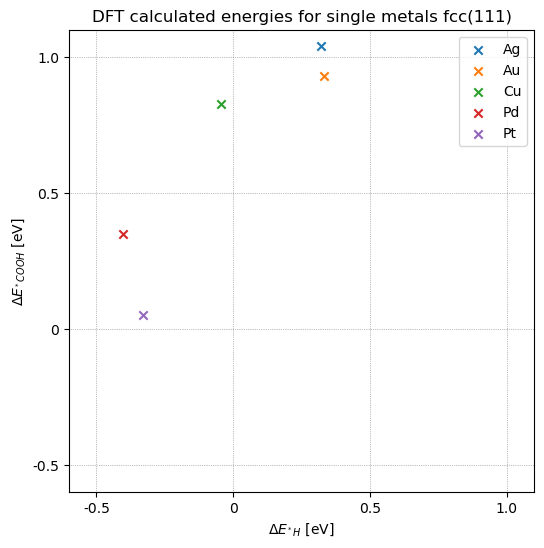

In [42]:
# Create a figure and axes
fig, ax = plt.subplots(figsize = (6, 6))

# Set the limits for both x and y axes
ax.set_xlim(-0.6, 1.1)
ax.set_ylim(-0.6, 1.1)

## Set the major ticks and tick labels
#ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_xticklabels([-0.5, '', 0, '', 0.5, '', 1.0])
#ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
#ax.set_yticklabels([-0.5, '', 0, '', 0.5, '', 1.0])

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([-0.5, 0, 0.5, 1.0])
ax.set_yticklabels([-0.5, 0, 0.5, 1.0])

# Set the grid lines
ax.grid(which='both', linestyle=':', linewidth=0.5, color='gray')

ax.set_title("DFT calculated energies for single metals fcc(111)")
ax.set_xlabel("$\Delta E_{^*H}$ [eV]")
ax.set_ylabel("$\Delta E_{^*COOH}$ [eV]")

for i, metal in enumerate(SE_slab_metals):
    ax.scatter(DeltaE_H[i], DeltaE_COOH[i], label = metal, marker = "x")
    #print(SE_H[i])
    #print(SE_COOH[i])
    
ax.legend()

# Show the plot
plt.show()

#### Training models for COOH and H

In [44]:
def correct_DFT_energy_COOH_DFT(molecules_dict, E_COOH, E_slab):
    return E_COOH - E_slab - molecules_dict["CO2"] - 1/2*molecules_dict["H2"]

def correct_DFT_energy_H_DFT(molecules_dict, E_H, E_slab):
    return E_H - E_slab - 1/2*molecules_dict["H2"]

In [67]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_H = 'H_out.db'
db_name_COOH = 'COOH_C_adsorbed_out.db'
db_name_slab = "slabs_out.db"

# Initiate feature readers
reader_H = FccStandard111(metals)
reader_COOH = OntopStandard111(metals)

site_ids_H = [16, 17, 18]

# Initiate counters of rejected samples
rejected_H = 0
rejected_COOH = 0

# Writer headers to files
with open(f'{features_folder}H_DFT_features.csv', 'w') as file_H:
    column_names = [f"feature{n}" for n in range(55)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_H}row')
    file_H.write(",".join(column_names))
    
# Writer headers to files
with open(f'{features_folder}COOH_DFT_features.csv', 'w') as file_COOH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_COOH}row')
    file_COOH.write(",".join(column_names))
    
# Load HEA(111) databases
with connect(f'{db_folder}{db_name_H}') as db_H,\
     connect(f'{db_folder}{db_name_COOH}') as db_COOH,\
     connect(f'{db_folder}{db_name_slab}') as db_slab,\
     open(f'{features_folder}H_DFT_features.csv', 'a') as file_H,\
     open(f'{features_folder}COOH_DFT_features.csv', 'a') as file_COOH:
    #print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0): # This doesn't even trigger lmao
        #print("A2")
        # Iterate through the two adsorbates
        for ads in ['COOH', 'H']:
            #print("A3")
            # Set adsorbate-specific parameters
            if ads == 'COOH':
                db = db_COOH
                kw = {'C': 1,'O': 2, 'H': 1}
                db_name = db_name_COOH
                out_file = file_COOH

            elif ads == 'H':
                db = db_H
                kw = {'O': 0, 'H': 0}
                db_name = db_name_H
                out_file = file_H

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    #print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # If the adsorbate is *COOH
                    if ads == 'COOH':
                        # Make slab instance
                        slab = Slab(atoms, ads=ads, ads_atom='C')

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_COOH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_COOH.get_features(slab, radius=2.6)
                        
                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_COOH_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

                    # Else, if the adsorbate is H*
                    elif ads == 'H':

                        # Make slab instance
                        slab = Slab(atoms, ads=ads, ads_atom='H')
                        
                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_O, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[20][:2]

                        # If the oxygen is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_O += 1
                            continue

                        # Get features of structure
                        features = reader_H.get_features(slab, radius=2.6, site_ids=site_ids_H)

                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_H_DFT(molecules_dict, row.energy, row_slab.energy) # This is the new formula
                        
                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected COOH samples: ', rejected_COOH)
print('rejected H samples: ', rejected_H)

[INFO] 9 COOH and slab matched for row 1 in slabs_out.db
[INFO] 9 COOH and slab matched for row 2 in slabs_out.db
[INFO] 9 COOH and slab matched for row 3 in slabs_out.db
[INFO] 9 COOH and slab matched for row 4 in slabs_out.db
[INFO] 9 COOH and slab matched for row 5 in slabs_out.db
[INFO] 9 COOH and slab matched for row 6 in slabs_out.db
[INFO] 9 COOH and slab matched for row 7 in slabs_out.db
[INFO] 9 COOH and slab matched for row 8 in slabs_out.db
[INFO] 9 COOH and slab matched for row 9 in slabs_out.db
[INFO] 9 COOH and slab matched for row 10 in slabs_out.db
[INFO] 9 COOH and slab matched for row 11 in slabs_out.db
[INFO] 9 COOH and slab matched for row 12 in slabs_out.db
[INFO] 9 COOH and slab matched for row 13 in slabs_out.db
[INFO] 9 COOH and slab matched for row 14 in slabs_out.db
[INFO] 9 COOH and slab matched for row 15 in slabs_out.db
[INFO] 9 COOH and slab matched for row 16 in slabs_out.db
[INFO] 9 COOH and slab matched for row 17 in slabs_out.db
[INFO] 9 COOH and slab 

In [64]:
feature_folder = "../csv_features/"
filename = "COOH_DFT_features.csv"

COOH_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([COOH_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

In [65]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_OH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_OH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_OH.save_model("../models/"+"OH.model")

learning_curve(XGBModel_OH)

score = XGBModel_OH.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_OH.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_OH, X_test, y_test, "OH", "OH") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.